# LAM Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import sklearn
import sklearn.model_selection as sklms
import sklearn.linear_model as skllm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier


from lam import ar, fft, ssa, semor
from lam import utils

from ensemble import Ensemble

from qpfs import qpfs

from tqdm.notebook import tqdm

### Loading and preprocessing data

In [2]:
with open("data/uci/activity_and_segment.pickle", "rb") as f:
    activity_and_segment = pickle.load(f)
    
a_s_l = []
for a_s in activity_and_segment:
    if 'WALKING' in a_s[0]:
        a_s_l.append(a_s)

activity_and_segment = a_s_l

In [3]:
segments = [pair[1] for pair in activity_and_segment]
actions = [pair[0] for pair in activity_and_segment]

normalized_segments = utils.normalize_segments(segments)

le = LabelEncoder()
Y = le.fit_transform(actions)

X = np.array(normalized_segments)

print('Data shape:', X.shape)
print('Labels shape:', Y.shape)

Data shape: (6307, 22)
Labels shape: (6307,)


#### Data shuffling

In [4]:
a = np.arange(0, X.shape[0])
np.random.shuffle(a)

X = X[a]
Y = Y[a]

### Making an ensemble

In [5]:
with open("data/semor_profiles/semor_profiles.pickle", "rb") as f:
    semor_profiles = pickle.load(f)

for key, profile in semor_profiles.items():
    semor_profiles[key] = utils.shrink_segment(profile, 20)

In [6]:
ens = Ensemble([ar.AR(5),
                fft.FFT(4),
                ssa.SSA(10),
                semor.Semor(semor_profiles['walk']),
                semor.Semor(semor_profiles['run']),
                semor.Semor(semor_profiles['up']),
                semor.Semor(semor_profiles['down'])])

print([model.name for model in ens.models])

['ar_5', 'fft_4', 'ssa_10', 'semor_228', 'semor_635', 'semor_688', 'semor_331']


In [7]:
ens.fit(X)

/home/danillich/.local/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarn

#### Ensembe parameters processing and selection

In [8]:
ens_params = ens.params.copy()
print(ens_params.shape)

deletion_list = []
for i in range(ens_params.shape[1]):
    if np.abs(ens_params[:, i].std()) < 1e-13:
        deletion_list.append(i)
print(deletion_list)
ens_params = np.delete(ens_params, deletion_list, axis=1)

for i in range(ens_params.shape[1]):
    ens_params[:, i] -= ens_params[:, i].mean()
    ens_params[:, i] /= ens_params[:, i].std()

print('Params shape', ens_params.shape)

(6307, 40)
[20, 22, 23, 25, 27, 28, 30, 32, 33, 35, 37, 38]
Params shape (6307, 28)


In [9]:
ens_params.mean(axis=0)

array([ 1.57723138e-16,  3.08686713e-16, -2.92914399e-17, -1.83071499e-17,
       -4.22472691e-18, -1.77438530e-17, -4.25007527e-16, -1.80255015e-16,
        2.42780973e-16, -1.60539622e-16,  3.54877060e-17, -3.80788718e-16,
        1.84761390e-16, -3.92054657e-16,  5.74562859e-17,  1.51245223e-16,
        3.11503197e-16,  6.02727705e-17, -5.09783713e-17,  9.68870704e-17,
       -1.07026415e-16,  1.87014578e-15, -1.80255015e-17, -2.36595973e-14,
       -2.87281430e-16, -4.46807117e-15, -1.23925323e-17, -1.34627964e-15])

In [10]:
ens_params.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [11]:
verbose = True

Q, b = qpfs.create_opt_problem(ens_params, Y, sim='correl', rel='correl', verbose=True)
qp_score = qpfs.solve_opt_problem(Q, b, verbose)

idx_qp = qp_score.argsort()[::-1]

Constructing the problem...
Similarity measure: correl, feature relevance measure: correl
Problem has been constructed.
Solving the QP problem...
The problem has been solved!
Problem status: optimal


# GLM

In [12]:
def fit_logreg(data, target, i, n_splits=10):
    scores = []
    accs = []

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=43)
    
    for train_idx, test_idx in kfold.split(data, target):
        x_train, x_test = data[train_idx], data[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]
    
        Q, b = qpfs.create_opt_problem(x_train, y_train, sim='correl', rel='correl')
        qp_score = qpfs.solve_opt_problem(Q, b)
        feature_mask = qp_score.argsort()[::-1][:i]
        
        x_train = x_train[:, feature_mask]
        x_test = x_test[:, feature_mask]

        _, l, _ = np.linalg.svd(x_train)

        model = skllm.LogisticRegression(max_iter=15000)
        model.fit(x_train, y_train)
        y_pred = model.predict_proba(x_test)
        scores.append(sklearn.metrics.log_loss(y_test, y_pred))
        accs.append(np.sum(y_test == model.predict(x_test))/y_test.shape[0])
        
    return np.array(accs), np.array(scores), l

In [13]:
accs_glm = []
scores_glm = []
lambdas_glm = []

for i in tqdm(range(1, qp_score.shape[0])):
    a, s, l = fit_logreg(ens_params, Y, i)
    
    lambdas_glm.append(l)
    accs_glm.append((i, a.mean(), a.std()))    
    scores_glm.append((i, s.mean(), s.std()))

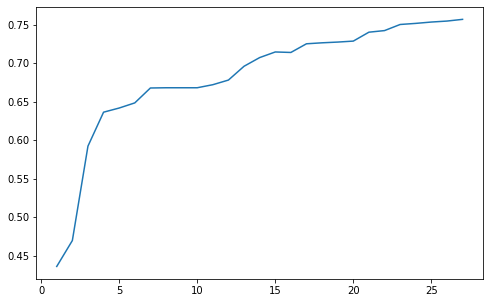

In [14]:
plt.figure(figsize=(8, 5))
plt.plot([a[0] for a in accs_glm], [a[1] for a in accs_glm])
plt.show()

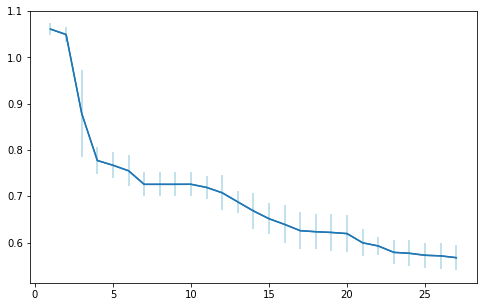

In [15]:
plt.figure(figsize=(8, 5))
plt.plot([a[0] for a in scores_glm], [a[1] for a in scores_glm])
plt.errorbar([a[0] for a in scores_glm],
             [a[1] for a in scores_glm],
             yerr=[a[2] for a in scores_glm],
             ecolor='lightblue')
plt.show()

In [16]:
lambdas_glm

[array([75.2464291]),
 array([96.5239938, 44.9619672]),
 array([102.2714699 ,  75.70243682,  28.38960336]),
 array([102.33331556,  84.46239155,  66.07010767,  25.92092193]),
 array([106.48830242, 100.63628458,  68.1873394 ,  39.13916985,
         25.81156046]),
 array([113.36557858, 104.86769388,  71.41376054,  56.18357168,
         38.94320831,  18.36622346]),
 array([126.66707642, 112.98251877,  72.80737963,  56.82140027,
         42.82163673,  18.45731649,  11.55213949]),
 array([1.46271561e+02, 1.13069905e+02, 7.34175772e+01, 5.71628122e+01,
        4.44362111e+01, 1.85208340e+01, 1.33829993e+01, 1.03218008e-12]),
 array([1.64030657e+02, 1.13091120e+02, 7.37502577e+01, 5.73695836e+01,
        4.52778604e+01, 1.85667953e+01, 1.41904312e+01, 1.98574524e-12,
        1.02620422e-12]),
 array([1.80234317e+02, 1.13100664e+02, 7.39580135e+01, 5.75069091e+01,
        4.57866221e+01, 1.86012725e+01, 1.46418991e+01, 2.12033115e-12,
        1.18904487e-12, 6.11279727e-13]),
 array([1.80425561

# 2NN

In [17]:
def fit_MLP(data, target, n_hid, n_splits=10):
    scores = []
    accs = []

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=40)
    
    for train_idx, test_idx in kfold.split(data, target):
        x_train, x_test = data[train_idx], data[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]
    
        model = MLPClassifier(hidden_layer_sizes=(n_hid), max_iter=5000, activation='logistic')
        model.fit(x_train, y_train)
        
        _, l, _ = np.linalg.svd(model.coefs_[0])
        
        y_pred = model.predict_proba(x_test)
        scores.append(sklearn.metrics.log_loss(y_test, y_pred))
        accs.append(np.sum(y_test == model.predict(x_test))/y_test.shape[0])
        
    return np.array(accs), np.array(scores), l

In [18]:
accs_base = []

scores_base = []
lambdas_base = []

for i in tqdm(range(1, qp_score.shape[0])):
    a, s, l = fit_MLP(X, Y, i)

    lambdas_base.append(l)
    accs_base.append((i, a.mean(), a.std()))    
    scores_base.append((i, s.mean(), s.std()))

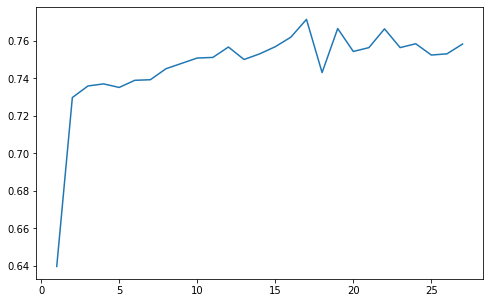

In [19]:
plt.figure(figsize=(8, 5))
plt.plot([a[0] for a in accs_base], [a[1] for a in accs_base])
plt.show()

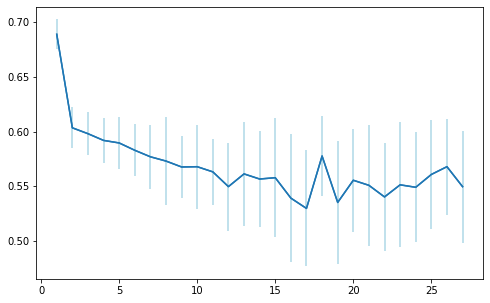

In [20]:
plt.figure(figsize=(8, 5))
plt.plot([a[0] for a in scores_base], [a[1] for a in scores_base])
plt.errorbar([a[0] for a in scores_base],
             [a[1] for a in scores_base],
             yerr=[a[2] for a in scores_base],
             ecolor='lightblue')
plt.show()

In [21]:
lambdas_base

[array([5.81108009]),
 array([6.7680169, 6.2234645]),
 array([7.58125953, 5.48922634, 1.12460337]),
 array([9.04198019, 6.3187683 , 2.13997731, 0.89243622]),
 array([7.81410945, 6.00420352, 0.71069816, 0.5608662 , 0.46231168]),
 array([9.00018272, 6.71754497, 1.11755446, 0.96020934, 0.68743218,
        0.55144444]),
 array([11.57472042,  8.48343059,  7.09823733,  5.35466874,  3.10691789,
         1.94287243,  0.77836595]),
 array([10.68418183,  7.22020999,  5.77747613,  2.90205718,  1.78211258,
         1.37029755,  0.72267533,  0.42827905]),
 array([9.41143239, 6.76233177, 1.51281409, 1.04158058, 0.59885033,
        0.58925796, 0.47896992, 0.40304116, 0.30692581]),
 array([9.71190832, 7.29999871, 2.07127943, 1.26198263, 0.77389991,
        0.69035297, 0.53587566, 0.4666534 , 0.39770542, 0.32659605]),
 array([11.8789742 ,  7.61545462,  6.04725874,  2.53158219,  1.87887722,
         1.41627617,  0.9259744 ,  0.7384945 ,  0.57876062,  0.44560308,
         0.25296522]),
 array([11.3752695

# Comparison

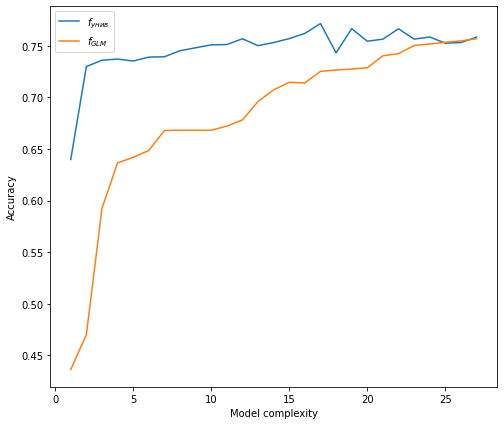

In [24]:
plt.figure(figsize=(8, 7))
plt.plot([a[0] for a in accs_base], [a[1] for a in accs_base], label=r'$f_{унив}}$')
plt.plot([a[0] for a in accs_glm], [a[1] for a in accs_glm], label=r'$f_{GLM}}$')
# plt.plot([a[0] for a in accs_ref], [a[1] for a in accs_ref], label=r'$f_{ref}}$')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.xlabel('Model complexity')
plt.show()

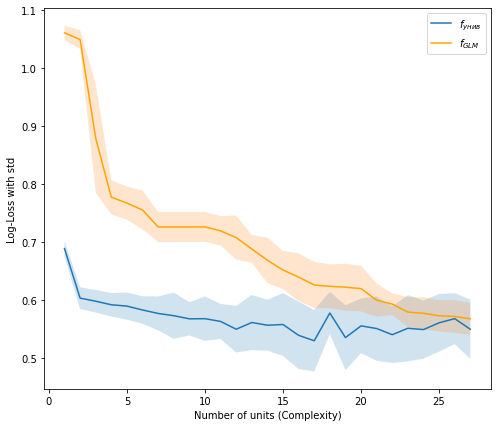

In [23]:
plt.figure(figsize=(8, 7))
plt.plot([a[0] for a in scores_base], [a[1] for a in scores_base], label=r'$f_{унив}}$')
plt.fill_between([a[0] for a in scores_base],
                 [a[1] - a[2] for a in scores_base],
                 [a[1] + a[2] for a in scores_base], alpha=0.2)

plt.plot([a[0] for a in scores_glm], [a[1] for a in scores_glm], label=r'$f_{GLM}}$', c='orange')
plt.fill_between([a[0] for a in scores_glm],
                 [a[1] - a[2] for a in scores_glm],
                 [a[1] + a[2] for a in scores_glm], alpha=0.2)

# plt.plot([a[0] for a in scores_ref], [a[1] for a in scores_ref], label=r'$f_{Ref}}$', c='green')
# plt.fill_between([a[0] for a in scores_ref],
#                  [a[1] - a[2] for a in scores_ref],
#                  [a[1] + a[2] for a in scores_ref], alpha=0.2)

plt.legend(loc='best')
plt.ylabel('Log-Loss with std')
plt.xlabel('Number of units (Complexity)')
plt.show()